In [27]:
# !pip install mediapipe opencv-python numpy pandas tensorflow scikit-learn matplotlib

# Extract Pose Keypoints from Videos

In [28]:
import os
import cv2
import mediapipe as mp
import numpy as np
from tqdm import tqdm


In [29]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

def extract_keypoints_from_video(video_path, max_frames=30):
    cap = cv2.VideoCapture(video_path)
    keypoints_seq = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or len(keypoints_seq) >= max_frames:
            break

        frame = cv2.resize(frame, (480, 360))
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(rgb)

        if result.pose_landmarks:
            keypoints = []
            for lm in result.pose_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
            keypoints_seq.append(keypoints)
        else:
            keypoints_seq.append([0] * 99)  # 33 keypoints * 3 coords

    cap.release()
    return keypoints_seq


# Processing Entire Dataset

In [19]:
import json
from sklearn.model_selection import train_test_split

DATASET_PATH = r"F:\quest_digiflex\exp\data\archive"
MAX_FRAMES = 30

data = []
labels = []
label_map = {}

for i, label in enumerate(sorted(os.listdir(DATASET_PATH))):
    label_map[label] = i
    class_path = os.path.join(DATASET_PATH, label)
    for video_file in tqdm(os.listdir(class_path), desc=f"Processing {label}"):
        video_path = os.path.join(class_path, video_file)
        keypoints_seq = extract_keypoints_from_video(video_path, max_frames=MAX_FRAMES)
        padded = keypoints_seq + [[0] * 99] * (MAX_FRAMES - len(keypoints_seq))  # pad
        data.append(padded[:MAX_FRAMES])
        labels.append(i)

np.savez("pose_sequences_30.npz", X=np.array(data), y=np.array(labels), label_map=label_map)


Processing tricep dips: 100%|██████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.38s/it]


# Train/Test Split & Normalize

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

loaded = np.load("pose_sequences_30.npz", allow_pickle=True)
X, y = loaded["X"], loaded["y"]
label_map = loaded["label_map"].item()

X = np.array(X)
y = to_categorical(y, num_classes=len(label_map))

# Flatten for normalization
scaler = StandardScaler()
X_flat = X.reshape(-1, X.shape[-1])
X_scaled = scaler.fit_transform(X_flat).reshape(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [31]:
def clean_sequences(sequences, labels):
    cleaned_X, cleaned_y = [], []
    for x, y in zip(sequences, labels):
        if x is None or len(x) == 0:
            continue
        if len(x[0]) != 99:
            continue
        cleaned_X.append(x)
        cleaned_y.append(y)
    return cleaned_X, cleaned_y

X_train, y_train = clean_sequences(X_train, y_train)
X_test, y_test = clean_sequences(X_test, y_test)


In [32]:
print(type(X_train))
print(len(X_train))
print(type(X_train[0]))
print(np.array(X_train[0]).shape)


<class 'list'>
521
<class 'numpy.ndarray'>
(30, 99)


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from pose_utils import normalize_keypoints, smooth_sequence  # your custom preprocessing

# Parameters
max_frames = 30
feature_dim = 99

# === Clean sequences function ===
def clean_sequences(sequences, labels):
    cleaned_X, cleaned_y = [], []
    for x, y in zip(sequences, labels):
        if x is None or len(x) == 0:
            continue
        if len(x[0]) != feature_dim:
            continue
        cleaned_X.append(x)
        cleaned_y.append(y)
    return cleaned_X, cleaned_y

# === Preprocessing function ===
def preprocess_sequences(X_raw, max_frames=max_frames):
    X_processed = []
    for seq in X_raw:
        seq = normalize_keypoints(seq)
        seq = smooth_sequence(seq)
        # Pad or truncate to max_frames
        seq += [[0] * feature_dim] * (max_frames - len(seq))
        seq = np.array(seq[:max_frames])
        X_processed.append(seq)
    return np.array(X_processed)

# ==== Assume X_train, y_train, X_test, y_test are loaded ====

# Clean sequences (remove bad samples)
X_train, y_train = clean_sequences(X_train, y_train)
X_test, y_test = clean_sequences(X_test, y_test)

# Preprocess sequences (normalize, smooth, pad/truncate)
X_train = preprocess_sequences(X_train)
X_test = preprocess_sequences(X_test)

# Feature scaling (fit on train only)
scaler = StandardScaler()
X_train = X_train.reshape(-1, feature_dim)
X_train = scaler.fit_transform(X_train)
X_train = X_train.reshape(-1, max_frames, feature_dim)

X_test = X_test.reshape(-1, feature_dim)
X_test = scaler.transform(X_test)
X_test = X_test.reshape(-1, max_frames, feature_dim)

# === Label encoding ===

# If labels are one-hot encoded, convert to class indices
if len(np.array(y_train).shape) == 2 and np.array(y_train).shape[1] > 1:
    y_train_int = np.argmax(y_train, axis=1)
    y_test_int = np.argmax(y_test, axis=1)
else:
    y_train_int = np.array(y_train)
    y_test_int = np.array(y_test)

label_encoder = LabelEncoder()
label_encoder.fit(y_train_int)

y_train_int = label_encoder.transform(y_train_int)
y_test_int = label_encoder.transform(y_test_int)

# One-hot encode for training
y_train_cat = to_categorical(y_train_int)
y_test_cat = to_categorical(y_test_int)

# === Build BiLSTM model ===
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(max_frames, feature_dim)),
    Dropout(0.4),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(y_train_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# === Train model ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# === Save model and label classes ===
model.save("pose_classifier_bilstm.h5")
np.save("label_classes.npy", label_encoder.classes_)

print("Training complete and model saved.")


C:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - accuracy: 0.1092 - loss: 3.0129 - val_accuracy: 0.2286 - val_loss: 2.7776
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2167 - loss: 2.7430 - val_accuracy: 0.3810 - val_loss: 2.4994
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3484 - loss: 2.3918 - val_accuracy: 0.4095 - val_loss: 2.2693
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3995 - loss: 2.1375 - val_accuracy: 0.4381 - val_loss: 2.1033
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5281 - loss: 1.7917 - val_accuracy: 0.4762 - val_loss: 2.0081
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5483 - loss: 1.6604 - val_accuracy: 0.4476 - val_loss: 1.9428
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5921 - loss: 1.5946 - val_accuracy: 0.4667 - val_loss: 1.8695
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6330 - loss: 1.3901 - val_accuracy: 0.4667 - v

Training complete and model saved.


# Build and Train LSTM Model

In [7]:
# %%time
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout

# model = Sequential([
#     LSTM(64, return_sequences=True, input_shape=(100, 99)),
#     Dropout(0.4),
#     LSTM(32),
#     Dense(32, activation='relu'),
#     Dropout(0.4),
#     Dense(len(label_map), activation='softmax')
# ])

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

# history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16)
# model.save("pose_classifier_lstm.h5")


C:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 64)             │          41,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 22)                  │             726 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,182 (219.46 KB)

 Trainable params: 56,182 (219.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.0640 - loss: 3.0788 - val_accuracy: 0.1333 - val_loss: 2.9109
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.1351 - loss: 2.8547 - val_accuracy: 0.2381 - val_loss: 2.7569
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.1829 - loss: 2.6765 - val_accuracy: 0.2857 - val_loss: 2.6009
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2341 - loss: 2.5142 - val_accuracy: 0.2476 - val_loss: 2.4339
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2620 - loss: 2.4453 - val_accuracy: 0.3238 - val_loss: 2.3718
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.2454 - loss: 2.3002 - val_accuracy: 0.3905 - val_loss: 2.2128
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3255 - loss: 2.1366 - val_accuracy: 0.4000 - val_loss: 2.0873
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3858 - loss: 2.0428 - val_accuracy: 0.4095 - 

CPU times: total: 2min 27s
Wall time: 1min 10s


In [3]:
# import cv2
# import numpy as np
# import mediapipe as mp

# mp_pose = mp.solutions.pose

# def extract_keypoints_from_video(video_path, max_frames=30):
#     cap = cv2.VideoCapture(video_path)
#     keypoints = []

#     with mp_pose.Pose(static_image_mode=False,
#                       min_detection_confidence=0.5,
#                       min_tracking_confidence=0.5) as pose:
#         while cap.isOpened():
#             ret, frame = cap.read()
#             if not ret:
#                 break
#             frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#             result = pose.process(frame_rgb)
#             if result.pose_landmarks:
#                 landmarks = result.pose_landmarks.landmark
#                 keypoint = [lm.x for lm in landmarks] + \
#                            [lm.y for lm in landmarks] + \
#                            [lm.z for lm in landmarks]
#                 keypoints.append(keypoint)
#         cap.release()

#     return keypoints[:max_frames]

# def normalize_keypoints(sequence):
#     """Center keypoints around hips and scale by shoulder-hip distance."""
#     sequence = np.array(sequence)
#     if sequence.shape[1] != 99:
#         return sequence
#     sequence = sequence.reshape(-1, 33, 3)
    
#     # Hip center: average of left and right hip (23, 24)
#     center = sequence[:, [23, 24], :].mean(axis=1, keepdims=True)

#     # Scale: distance between shoulders (11, 12)
#     shoulder_dist = np.linalg.norm(sequence[:, 11, :] - sequence[:, 12, :], axis=1)
#     shoulder_dist = shoulder_dist[:, np.newaxis, np.newaxis] + 1e-6

#     normalized = (sequence - center) / shoulder_dist
#     return normalized.reshape(-1, 99)

# def smooth_sequence(sequence, window=3):
#     smoothed = []
#     for i in range(len(sequence)):
#         start = max(0, i - window)
#         end = min(len(sequence), i + window + 1)
#         smoothed.append(np.mean(sequence[start:end], axis=0))
#     return smoothed


In [19]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.preprocessing import StandardScaler
# from pose_utils import normalize_keypoints, smooth_sequence  # Ensure your pose_utils has these

# def preprocess_sequences(X_raw, max_frames=30):
#     X_processed = []
#     for seq in X_raw:
#         print(f"seq shape before normalize: {np.array(seq).shape}")
#         seq = normalize_keypoints(seq)
#         seq = smooth_sequence(seq)
#         seq += [[0] * 99] * (max_frames - len(seq))  # pad
#         seq = np.array(seq[:max_frames])
#         X_processed.append(seq)
#     return np.array(X_processed)



# max_frames = 30  # Must match your preprocess setting

# # Apply preprocessing
# X_train = preprocess_sequences(X_train)
# X_test = preprocess_sequences(X_test)

# # Optional: Normalize values across dataset
# scaler = StandardScaler()
# num_train_samples = X_train.shape[0]  # Save original number of samples
# X_train = X_train.reshape(-1, 99)
# X_train = scaler.fit_transform(X_train)
# X_train = X_train.reshape(num_train_samples, max_frames, 99)

# num_test_samples = X_test.shape[0]
# X_test = X_test.reshape(-1, 99)
# X_test = scaler.transform(X_test)
# X_test = X_test.reshape(num_test_samples, max_frames, 99)


# # Define model
# model = Sequential([
#     Bidirectional(LSTM(64, return_sequences=True), input_shape=(100, 99)),
#     Dropout(0.4),
#     Bidirectional(LSTM(32)),
#     Dense(32, activation='relu'),
#     Dropout(0.4),
#     Dense(len(label_map), activation='softmax')
# ])

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Early stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train
# history = model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     epochs=50,
#     batch_size=16,
#     callbacks=[early_stop],
#     verbose=1
# )

# # Save model
# model.save("pose_classifier_bilstm.h5")


seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
seq shape before normalize: (30, 99)
s

C:\Users\prana\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 416
'y' sizes: 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22


In [26]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from tensorflow.keras.utils import to_categorical
# from pose_utils import normalize_keypoints, smooth_sequence  # your custom preprocessing

# # Parameters
# max_frames = 30
# feature_dim = 99

# # === Preprocessing function ===
# def preprocess_sequences(X_raw, max_frames=max_frames):
#     X_processed = []
#     for seq in X_raw:
#         seq = normalize_keypoints(seq)
#         seq = smooth_sequence(seq)
#         # Pad or truncate sequence
#         seq += [[0] * feature_dim] * (max_frames - len(seq))
#         seq = np.array(seq[:max_frames])
#         X_processed.append(seq)
#     return np.array(X_processed)

# # --- Your raw inputs ---
# # X_train_raw, X_test_raw are list of pose sequences (each sequence is list of frames with 99-dim keypoints)
# # y_train_raw, y_test_raw are 1D arrays or lists of string labels (e.g., 'squat', 'pushup', etc.)

# # === Preprocess input sequences ===
# X_train = preprocess_sequences(X_train)
# X_test = preprocess_sequences(X_test)

# # === Feature Scaling ===
# scaler = StandardScaler()
# X_train = X_train.reshape(-1, feature_dim)
# X_train = scaler.fit_transform(X_train)
# X_train = X_train.reshape(-1, max_frames, feature_dim)

# X_test = X_test.reshape(-1, feature_dim)
# X_test = scaler.transform(X_test)
# X_test = X_test.reshape(-1, max_frames, feature_dim)

# # === Encode labels ===
# label_encoder = LabelEncoder()
# y_train_int = label_encoder.fit_transform(y_train)
# y_test_int = label_encoder.transform(y_test)

# # Save label mapping for later use
# label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# # One-hot encode integer labels
# y_train = to_categorical(y_train_int)
# y_test = to_categorical(y_test_int)

# # === Build BiLSTM model ===
# model = Sequential([
#     Bidirectional(LSTM(64, return_sequences=True), input_shape=(max_frames, feature_dim)),
#     Dropout(0.4),
#     Bidirectional(LSTM(32)),
#     Dense(32, activation='relu'),
#     Dropout(0.4),
#     Dense(y_train.shape[1], activation='softmax')  # number of classes
# ])

# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # === Training ===
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# history = model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     epochs=50,
#     batch_size=16,
#     callbacks=[early_stop],
#     verbose=1
# )

# # === Save model and label classes ===
# model.save("pose_classifier_bilstm.h5")
# np.save("label_classes.npy", label_encoder.classes_)


ValueError: y should be a 1d array, got an array of shape (521, 22) instead.

In [23]:
print(type(X_train))
print(len(X_train))
print(type(X_train[0]))
print(np.array(X_train[0]).shape)


<class 'numpy.ndarray'>
521
<class 'numpy.ndarray'>
(30, 99)


# Evaluate Modelm

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Accuracy: 0.5572519083969466

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        14
           1       0.59      0.94      0.73        17
           2       1.00      0.33      0.50         6
           3       0.55      0.86      0.67         7
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         6
           6       1.00      0.25      0.40         4
           7       0.67      0.29      0.40         7
           8       0.67      0.86      0.75         7
           9       0.39      0.78      0.52         9
          10       0.67      0.50      0.57         4
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.60      1.00      0.75         3
          14       0.79      0.92      0.85        12
          15       0.00      0.00      0.00 

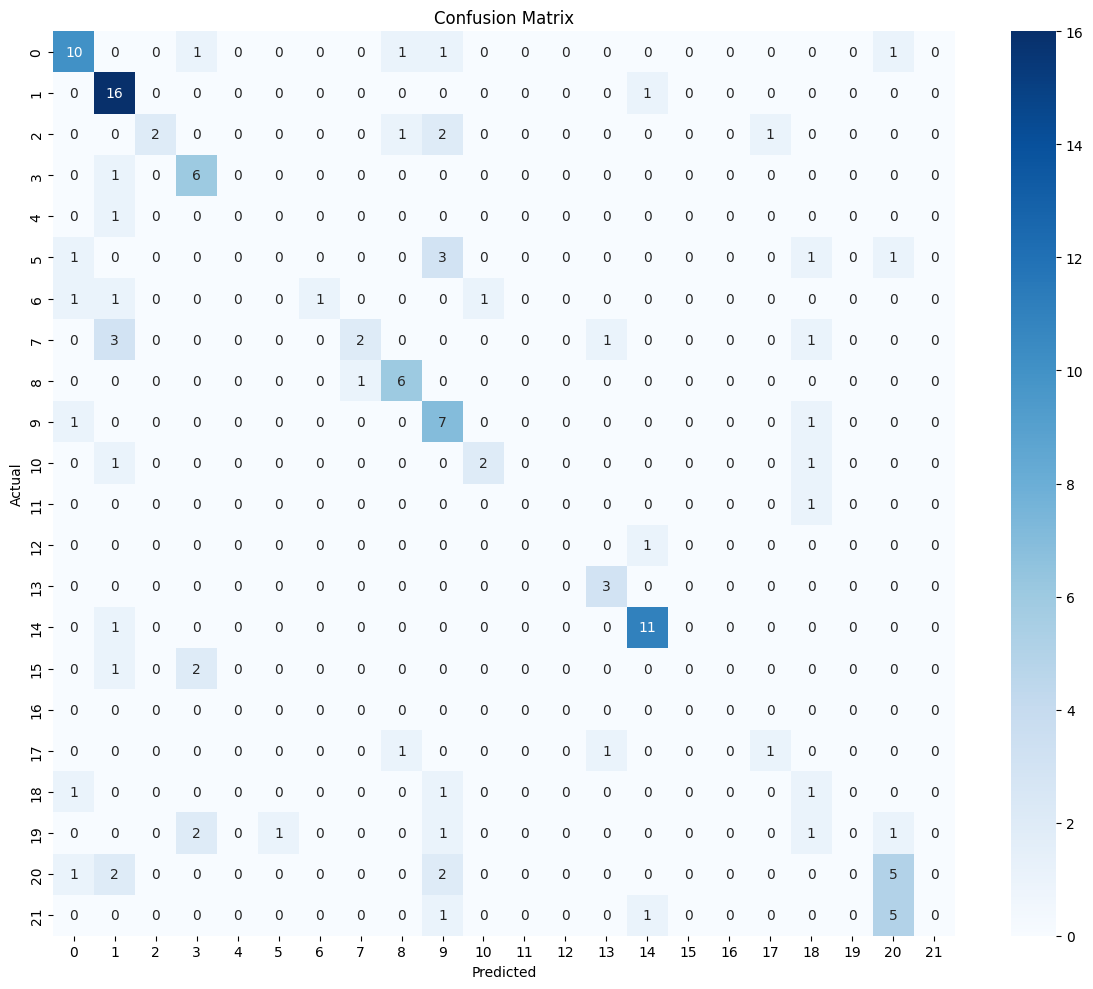

In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# === Predict on test data ===
y_pred_prob = model.predict(X_test)
y_pred_int = np.argmax(y_pred_prob, axis=1)
y_true_int = np.argmax(y_test_cat, axis=1)

# === Class labels and names ===
all_labels = np.arange(len(label_encoder.classes_))
class_names = [str(label) for label in label_encoder.classes_]

# === Evaluation metrics ===
accuracy = accuracy_score(y_true_int, y_pred_int)
print("Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(
    y_true_int,
    y_pred_int,
    labels=all_labels,
    target_names=class_names,
    zero_division=0
))

# === Confusion matrix ===
cm = confusion_matrix(y_true_int, y_pred_int, labels=all_labels)

# === Plotting ===
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_map.keys()))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


ValueError: Number of classes, 21, does not match size of target_names, 22. Try specifying the labels parameter

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Accuracy
acc = accuracy_score(y_true, y_pred_classes)
print(f"\n✅ Accuracy: {acc:.4f}")

# Optional: Detailed report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_map.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.keys(), yticklabels=label_map.keys(), cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

✅ Accuracy: 0.5573

Classification Report:


ValueError: Number of classes, 21, does not match size of target_names, 22. Try specifying the labels parameter

# Inference on New Video

In [40]:
def predict_video_class(video_path, model, scaler):
    keypoints_seq = extract_keypoints_from_video(video_path)
    padded = keypoints_seq + [[0] * 99] * (MAX_FRAMES - len(keypoints_seq))
    padded = np.array(padded[:MAX_FRAMES])
    padded_scaled = scaler.transform(padded)
    padded_scaled = np.expand_dims(padded_scaled, axis=0)

    prediction = model.predict(padded_scaled)
    return list(label_map.keys())[np.argmax(prediction)]


In [ ]:
# "F:\quest_digiflex\exp\data\squat\Bodyweight Squats.mp4"

In [45]:
# Load everything 
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Load model
model = tf.keras.models.load_model("pose_classifier_bilstm.h5")

# Load label map
data = np.load("pose_sequences_30.npz", allow_pickle=True)
label_map = data['label_map'].item()

# Recreate and fit the scaler (must use training data or saved scaler)
X = data['X']
X_flat = X.reshape(-1, X.shape[-1])
scaler = StandardScaler()
scaler.fit(X_flat)


StandardScaler()

In [46]:
def predict_video_class(video_path, model, scaler, label_map, max_frames=30):
    keypoints_seq = extract_keypoints_from_video(video_path, max_frames=max_frames)

    # Pad or truncate sequence
    padded = keypoints_seq + [[0] * 99] * (max_frames - len(keypoints_seq))
    padded = np.array(padded[:max_frames])

    # Normalize
    padded_scaled = scaler.transform(padded)
    padded_scaled = np.expand_dims(padded_scaled, axis=0)

    # Predict
    prediction = model.predict(padded_scaled)
    predicted_class = list(label_map.keys())[np.argmax(prediction)]

    print(f"\n✅ Predicted Exercise Class: {predicted_class}")
    return predicted_class


In [47]:
video_path = "F:\quest_digiflex\exp\data\squat\Bodyweight Squats.mp4"
predict_video_class(video_path, model, scaler, label_map)


<>:1: SyntaxWarning: invalid escape sequence '\q'
<>:1: SyntaxWarning: invalid escape sequence '\q'
C:\Users\prana\AppData\Local\Temp\ipykernel_6764\1747601094.py:1: SyntaxWarning: invalid escape sequence '\q'
  video_path = "F:\quest_digiflex\exp\data\squat\Bodyweight Squats.mp4"


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step

✅ Predicted Exercise Class: incline bench press


'incline bench press'

In [48]:
# "F:\quest_digiflex\exp\PullUP.mp4"
video_path = "F:\quest_digiflex\exp\PullUP.mp4"

predict_video_class(video_path, model, scaler, label_map)


<>:2: SyntaxWarning: invalid escape sequence '\q'
<>:2: SyntaxWarning: invalid escape sequence '\q'
C:\Users\prana\AppData\Local\Temp\ipykernel_6764\2027768811.py:2: SyntaxWarning: invalid escape sequence '\q'
  video_path = "F:\quest_digiflex\exp\PullUP.mp4"


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

✅ Predicted Exercise Class: bench press


'bench press'

In [16]:
# !pip install pose_utils

ERROR: Could not find a version that satisfies the requirement pose_utils (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for pose_utils


# test on test data 

In [17]:
import os
import numpy as np
import tensorflow as tf
from pose_utils import extract_keypoints_from_video, smooth_sequence, normalize_keypoints
from sklearn.preprocessing import StandardScaler

# Load trained model and data
model = tf.keras.models.load_model("pose_classifier_lstm.h5")
data = np.load("pose_sequences.npz", allow_pickle=True)
label_map = data['label_map'].item()
scaler = StandardScaler()
scaler.fit(data['X'].reshape(-1, data['X'].shape[-1]))

# Invert label_map for readability
inv_label_map = {v: k for k, v in label_map.items()}

def predict_video_class(video_path, model, scaler, label_map, max_frames=100):
    keypoints_seq = extract_keypoints_from_video(video_path, max_frames=max_frames)
    keypoints_seq = smooth_sequence(keypoints_seq)
    keypoints_seq = normalize_keypoints(keypoints_seq)

    # Pad or truncate sequence
    padded = keypoints_seq + [[0] * 99] * (max_frames - len(keypoints_seq))
    padded = np.array(padded[:max_frames])

    # Normalize
    padded_scaled = scaler.transform(padded)
    padded_scaled = np.expand_dims(padded_scaled, axis=0)

    # Predict
    prediction = model.predict(padded_scaled, verbose=0)
    predicted_class = list(label_map.keys())[np.argmax(prediction)]
    confidence = np.max(prediction)
    return predicted_class, confidence

# Directory of test videos
test_folder = "test"

for file in os.listdir(test_folder):
    if not file.endswith(".mp4"): continue
    video_path = os.path.join(test_folder, file)
    predicted_class, conf = predict_video_class(video_path, model, scaler, label_map)
    print(f"🎥 {file} → 🏷️ Predicted: {predicted_class} (confidence: {conf:.2f})")


ModuleNotFoundError: No module named 'pose_utils'